# Uplift Modeling Evaluation

*Author: Mingyuan Hua* 

The most basic method to predict uplift is Two-Model method, which uses two separate probabilistic models. For this method any classification model can be used, so I used Logistic Regression in my part.

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
from sklearn.metrics import hamming_loss
from sklearn.metrics import log_loss
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

# load the 10% sample data
df = pd.read_pickle('data10.pkl')

#### Normalize the features using min-max normalization

In [19]:
df=(df-df.min())/(df.max()-df.min())
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion
0,0.749497,0.0,0.241665,0.859044,0.0,0.000000,0.562556,1.000000,0.625676,0.054955,1.0,0.0,1.0,0.0
1,0.920650,0.0,0.650162,0.752415,0.0,0.092662,0.559090,0.318904,0.654606,0.000000,1.0,0.0,1.0,0.0
2,0.883087,0.0,0.453524,0.459807,0.0,0.000000,0.434624,1.000000,0.672016,0.054955,1.0,0.0,1.0,0.0
3,0.940470,0.0,0.480816,0.830997,0.0,0.000000,0.599129,1.000000,0.424812,0.331028,1.0,0.0,1.0,0.0
4,0.989895,0.0,0.563187,0.501783,0.0,0.000000,0.517447,1.000000,0.607643,0.000000,1.0,0.0,1.0,0.0


### Average Treatment Effect (ATE)

In [20]:
base = df[df.treatment == 0]
variant = df[df.treatment == 1]
    
delta = variant.conversion.mean() - base.conversion.mean()

delta_err = 1.96 * np.sqrt(variant.conversion.var() / variant.shape[0] + base.conversion.var() / base.shape[0])
  
print("Control: %s, N = %s, Conversion Rate: %s" % ( df[df.treatment == 0]['conversion'].sum(), df[df.treatment == 0].shape[0], 
                                         df[df.treatment == 0]['conversion'].sum() / float(df[df.treatment == 0].shape[0])))

print("\nTest: %s, N = %s, Conversion Rate: %s" % (df[df.treatment == 1]['conversion'].sum(), df[df.treatment == 1].shape[0], 
                                      df[df.treatment == 1]['conversion'].sum() / float(df[df.treatment == 1].shape[0])))

print("\nEstimated Effect %s, Standard Error: %s" % (delta, delta_err))

lift = delta / base.conversion.mean()
print("\nLift: %s" % lift)

# Run a t-test between the exposed and control group
t = stats.ttest_ind(df[df.treatment == 1]['conversion'], df[df.treatment == 0]['conversion'])
print("\nTest Statistic: %s, P-Value: %s" % (t[0], t[1]))

Control: 676.0, N = 389658, Conversion Rate: 0.0017348546674263072

Test: 5142.0, N = 2144718, Conversion Rate: 0.002397517995372818

Estimated Effect 0.0006626633279465108, Standard Error: 0.0001461446285707913

Lift: 0.381970513374233

Test Statistic: 7.951284352463762, P-Value: 1.84662795308898e-15


#### ATE Results 

Above, we can see there is a difference in conversion rate between the control and test, resulting in a 38% lift in conversion. Albeit, the conversion rate is very low at .17% and .23% for control and test, respectively. 

Now that we have established that there is a difference is test and control conversion rates, we can proceed with Uplift Modeling. 

Moving forward, we will build a model to predict conversion on the treatment dataset. We will use under sampling to balance the outcome class during training.

#### Logistic Regression

* For the classification we use Logistic Regression model with **default** parameters from Scikit-Learn Python library with **90/10** train/test splits ratio.

* The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)).

In [53]:
clf=LogisticRegression()

# split the data
X_train, X_test, y_train, y_test = train_test_split(df[df.columns[:-1]], df[['treatment','conversion']], test_size=0.1, random_state=35)

# treatment
# fits on treatment group and predicts probability PT (Y = 1|X ) 
fit_t = clf.fit(X_train[X_train.columns[:-1]][X_train.treatment == 1], y_train['conversion'][y_train.treatment == 1])
pt_pred = fit_t.predict_proba(X_test[X_train.columns[:-1]])[:,1]
yt_pred = fit_t.predict(X_test[X_train.columns[:-1]])

# control
# fits on control group and predicts PC (Y = 1|X )
fit_c = clf.fit(X_train[X_train.columns[:-1]][X_train.treatment == 0], y_train['conversion'][y_train.treatment == 0])
pc_pred = fit_c.predict_proba(X_test[X_train.columns[:-1]])[:,1]
yc_pred = fit_c.predict(X_test[X_train.columns[:-1]])

#### Two-model approach

In [54]:
u = pt_pred - pc_pred
test_df = y_test
test_df['pt'] = pt_pred
test_df['pc'] = pc_pred
test_df['u'] = u
test_df = test_df.sort_values('u', ascending=False)
test_df['yt'] = yt_pred
test_df['yc'] = yc_pred
test_df['yt'] = test_df['yt'].astype(np.int64)
test_df['yc'] = test_df['yc'].astype(np.int64)
test_df['treatment'] = test_df['treatment'].astype(np.int64)
test_df['conversion'] = test_df['conversion'].astype(np.int64)
test_df.head()

,treatment,conversion,pt,pc,u,yt,yc
432892,1,1,0.622071,0.398032,0.224039,0,0
421283,1,0,0.629557,0.407909,0.221648,0,0
6480,1,0,0.692042,0.474031,0.218012,0,0
263190,1,1,0.702279,0.488038,0.214241,0,0
88609,1,0,0.663994,0.454019,0.209975,0,0


#### Treatment group results

We can see the **accuracy** for the treatment model to predict the treatments is **99.70%**.

In [55]:
accuracy = accuracy_score(test_df[test_df.treatment==1]['conversion'], test_df[test_df.treatment==1]['yt'])
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 99.70%


### Gain Curve

Before we explore Uplift specific evaluation metrics, it is useful to create a gains chart and Gini coefficient, as traditional metrics used in Uplift modeling can be thought of as a generalization of the Gini coefficient. 
    
To create a gains chart we follow a few simple steps:

1. Sort by probability of conversion (descending). 
2. Create array for cumulative sum of conversions.
3. Create array for number of users targeted. 
4. Plot targeted users on the Y axis and conversions on the X axis. 

Text(0.5,1,u'Gain Chart')

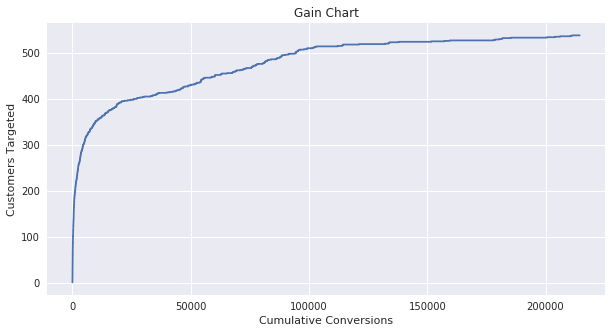

In [56]:
plt.rcParams['figure.figsize'] = [10, 5]
test_df = test_df.sort_values(by=['pt'], ascending=False)
number_purchases = test_df[test_df.treatment == 1]['conversion'].cumsum()
number_targeted  = test_df[test_df.treatment == 1]['treatment'].cumsum()
plt.plot(number_targeted, number_purchases)
plt.xlabel("Cumulative Conversions")
plt.ylabel("Customers Targeted")
plt.title("Gain Chart")

Now in order to make this chart more intuitive we need to add some perspective. We will do this by graphing a baseline (random) model and a perfect model. 

- Random: This just assigns a random probability of conversion for every row.
- Perfect: This sorts dataframe by conversions, so that every person who converts get targeted before a non-converter. 

In [57]:
# add random targeting
np.random.seed(35)

test_df['random_prob'] = [np.random.random() for k in test_df.index]
test_df = test_df.sort_values(by=['random_prob'], ascending=False)
# for treatment results
rand_number_purchases = test_df[test_df.treatment == 1]['conversion'].cumsum()
rand_number_targeted  = test_df[test_df.treatment == 1]['treatment'].cumsum()

# add optimal targeting  
test_df = test_df.sort_values(by=['conversion'], ascending=False)
optimum_number_purchases = test_df[test_df.treatment == 1]['conversion'].cumsum()
optimum_number_targeted  = test_df[test_df.treatment == 1]['treatment'].cumsum()

Text(0.5,1,u'Gains Chart')

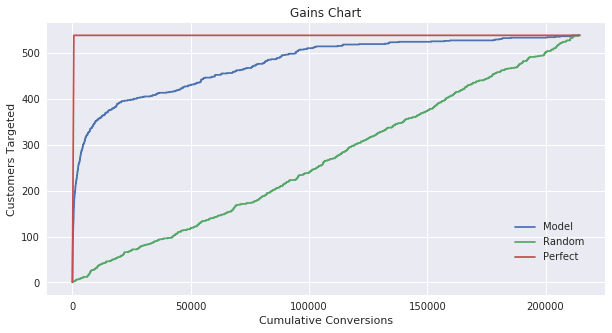

In [58]:
plt.plot(number_targeted, number_purchases, label='Model')
plt.plot(rand_number_targeted, rand_number_purchases, label='Random')
plt.plot(optimum_number_targeted, optimum_number_purchases, label='Perfect')
plt.xlabel("Cumulative Conversions")
plt.ylabel("Customers Targeted")
plt.legend(loc='upper center', bbox_to_anchor=(0.9, 0.3), fancybox=True, shadow=True)
plt.title("Gains Chart")

The chart above gives us a good visualization of how well are the logistic model performs compared to a random and perfect model. This is where the Gini Coefficient comes in. 

### Gini Coefficient

From the gains chart, one defines the Gini coefficient as the ratio between two areas:
- The area above the diagonal line (random model) and the cumulative gains line; 
- The area between the diagonal and the optimum
- https://www.kaggle.com/batzner/gini-coefficient-an-intuitive-explanation

Below, we will calculate this. 

In [59]:
def gini(actual, pred):
    assert (len(actual) == len(pred))
    all = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)
    all = all[np.lexsort((all[:, 2], -1 * all[:, 1]))]
    totalLosses = all[:, 0].sum()
    giniSum = all[:, 0].cumsum().sum() / totalLosses

    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)


def gini_normalized(actual, pred):
    return gini(actual, pred) / gini(actual, actual)
  
gini_predictions = gini(test_df[test_df.treatment == 1]['conversion'], test_df[test_df.treatment == 1]['yt'])
gini_max = gini(test_df[test_df.treatment == 1]['conversion'], test_df[test_df.treatment == 1]['conversion'])
ngini= gini_normalized(test_df[test_df.treatment == 1]['conversion'], test_df[test_df.treatment == 1]['yt'])
print('Gini: %.3f, Max. Gini: %.3f, Normalized Gini: %.3f' % (gini_predictions, gini_max, ngini))

Gini: 0.498, Max. Gini: 0.499, Normalized Gini: 0.999


### Uplift Curve

Draw a typical Uplift curve, as used to compute AUUC.

In [60]:
control_total   = test_df[test_df.treatment == 0].shape[0]
treatment_total = test_df[test_df.treatment == 1].shape[0]
N = len(test_df)

uplift = pd.DataFrame({'segment': np.arange(0,1.01, .01), 'control_pop': np.arange(0,1.01, .01) * control_total,
                       'treatment_pop': np.arange(0,1.01, .01) * treatment_total})

# format the counts to inte
uplift['treatment_pop'] = uplift['treatment_pop'].astype(int)
uplift['control_pop'] = uplift['control_pop'].astype(int)

# uplift curve using two-model approach
uplift['r_tk'] = uplift['treatment_pop'].apply(lambda x: test_df[test_df.treatment == 1].sort_values(by=['u'], ascending=False)['conversion'][:x].sum())
uplift['r_ck'] = uplift['control_pop'].apply(lambda x: test_df[test_df.treatment == 0].sort_values(by=['u'] , ascending=False)['conversion'][:x].sum())


# randome curve is the baseline
uplift['rand_tk'] = uplift['treatment_pop'].apply(lambda x: test_df[test_df.treatment == 1].sort_values(by=['random_prob'], ascending=False)['conversion'][:x].sum())
uplift['rand_ck'] = uplift['control_pop'].apply(lambda x: test_df[test_df.treatment == 0].sort_values(by=['random_prob'], ascending=False)['conversion'][:x].sum())

# for perfect we need to sort by incremental 
uplift['perfect_tk'] = uplift['treatment_pop'].apply(lambda x: test_df[test_df.treatment == 1].sort_values(by=['conversion'], ascending=False)['conversion'][:x].sum())
uplift['perfect_ck'] = uplift['control_pop'].apply(lambda x: test_df[test_df.treatment == 0].sort_values(by=['conversion'] )['conversion'][:x].sum())

# sleeping dogs
uplift['pract_tk'] = uplift['treatment_pop'].apply(lambda x: test_df[test_df.treatment == 1].sort_values(by=['conversion'], ascending=False)['conversion'][:x].sum())
uplift['pract_ck'] = uplift['control_pop'].apply(lambda x: test_df[test_df.treatment == 0].sort_values(by=['conversion'], ascending=False )['conversion'][:x].sum())

# calculate uplift 
uplift['uplift'] = uplift['r_tk'] - uplift['r_ck']
uplift['rand'] = uplift['rand_tk'] - uplift['rand_ck']
uplift['perfect'] = uplift['perfect_tk'] - uplift['perfect_ck']
uplift['pract'] = uplift['pract_tk'] - uplift['pract_ck']

uplift['uplift_ratio'] = uplift['uplift'] / N
uplift['rand_ratio'] = uplift['rand'] / N
uplift['perfect_ratio'] = uplift['perfect'] / N
uplift['pract_ratio'] = uplift['pract'] / N

uplift = uplift.fillna(0)

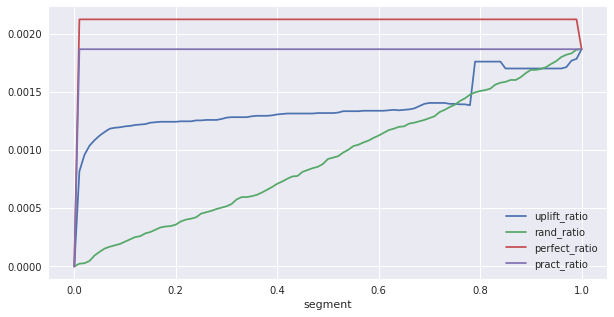

In [61]:
uplift.plot(kind='line',x='segment',y=['uplift_ratio', 'rand_ratio', 'perfect_ratio', 'pract_ratio'])
plt.show()

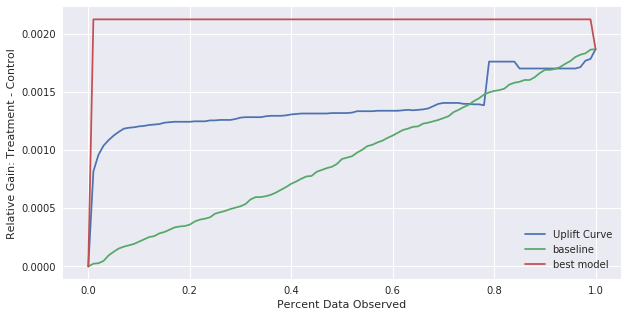

In [62]:
uplift.plot(kind='line',x='segment',y=['uplift_ratio', 'rand_ratio', 'perfect_ratio'])
plt.legend(['Uplift Curve', 'baseline', 'best model'])
plt.ylabel('Relative Gain: Treatment - Control')  
plt.xlabel('Percent Data Observed')
plt.show()

### Area Under Uplift Curve (AUUC) 

Area Under Uplift Curve (AUUC) is based on lift curves which represent the proportion of positive outcomes (the sen- sitivity) as a function of the percentage of the individuals selected. Lift curve has the same ordinate as the ROC, but a different abscissa. Uplift curve is defined as the difference in lift produced by a classi- fier between treatment and control groups, at a particular threshold percentage k/n of all examples. 

### From Gini to Qini 

Now, using the Gini metric/curve for evaluating an Uplift Modeling doesn't make as much sense as we don't know the true counterfactual outcome. That is, we want to see how well our Uplift model is at predicting uplift, but since we don't know the outcome of the counterfactual (i.e. what somebody would have done given other action), we can't plot this at an individual level. 

However, we can compare segments of the population. For example, we can sort the dataframe by uplift score (descending). Then for each decile in test and control we calculate the number of positive outcomes. We then subtract the number of positive outcomes in treatment minus the number in control. This give us incremental sales or uplift per decile. 

Now let's step back, for a second, and think about why this makes sense. If we sort by uplift and segment test and control populations by decile, the first decile in the test group should have a large number of converters. These are people how we predicted would convert when shown an ad, and since they are in the treatment group they were shown and ad. Furthermore, we would expect the control to have a low number of conversions. We also predicted they'd convert if shown and ad, however they were not shown and ad, so their likelihood of converting is, most likely, very small. Ideally we will see the highest uplift in the first decile, then it should decrease and level off until the last deciles where we could/should see negative uplift. If we see negative uplift (downlift) in segments we are observing what is known as sleeping dogs (customers who will buy without seeing and ad, but will not buy if they do see an ad). 

Below, we will build a model for the control group. We will then subtract the output probabilities of the test model and control model to come up with predicted uplift (two-model approach), after which we will build an Uplift plot. 


/usr/local/envs/py2env/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/usr/local/envs/py2env/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/usr/local/envs/py2env/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/envs/py2env/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in double_scalars


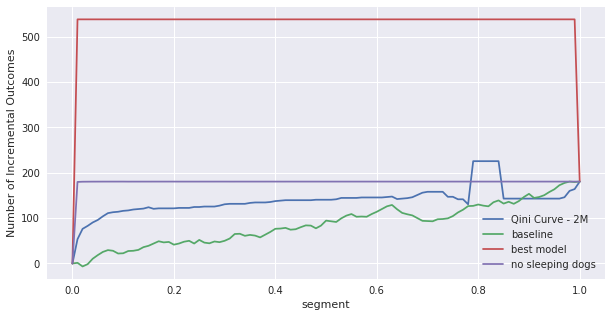

In [63]:
# calculate qini 
uplift['uplift_qini'] = uplift.apply(lambda x: x['r_tk'] - x['r_ck'] * x['treatment_pop'] / x['control_pop'], axis=1)
uplift['rand_qini'] = uplift.apply(lambda x: x['rand_tk'] - x['rand_ck'] * x['treatment_pop'] / x['control_pop'], axis=1)
uplift['perfect_qini'] = uplift.apply(lambda x: x['perfect_tk'] - x['perfect_ck'] * x['treatment_pop'] / x['control_pop'], axis=1)
uplift['pract_qini'] = uplift.apply(lambda x: x['pract_tk'] - x['pract_ck'] * x['treatment_pop'] / x['control_pop'], axis=1)

uplift['k'] = uplift['treatment_pop'] + uplift['control_pop']

uplift = uplift.fillna(0)

# Draw typical Qini curve
uplift.plot(kind='line',x='segment',y=['uplift_qini', 'rand_qini', 'perfect_qini', 'pract_qini'])
plt.legend(['Qini Curve - 2M', 'baseline', 'best model', 'no sleeping dogs'])
plt.ylabel('Number of Incremental Outcomes')  
#plt.xlabel('Number Targeted')
plt.show()

In [64]:
qini = (uplift.uplift_qini.sum() - uplift.rand_qini.sum())/(uplift.perfect_qini.sum() - uplift.rand_qini.sum())
print('Qini coefficient Q: %.3f' % qini)

Qini coefficient Q: 0.117


Similar to the Gini Coeffecient, the Qini coefficient is calculated by taking the ratio of two areas:
1. The area between the random curve and the Qini Curve.
2. The area between the random curve and the perfect curve.
    - As we discuss below, there are two options for the prefect curve. 

The perfect targeting curve can take many different forms. Two are outlined below. 

1. No Negative Effect (No Sleeping Dogs)
    - In this curve, we make the assumption that targeting somebody with an Ad can not have any negative effects i.e. no sleeping dogs. We can see this curve above in the red line. 
2. Negative Effects.
    - In this curve, we make the assume the perfect model, predicts all incremental sales first and puts any negative effects at the end of the model. 


### Additional Metrics

The Qini coefficient and curve have many variants that have been developed overtime. Below we will look at a few common variants and their benefits. 

- Cumulative Gain 

- Adjusted Qini Curve 